# Introduction 
For decades, cardiovascular diseases have been the leading cause of death. According to the most recent WHO data, coronary heart disease deaths in Egypt accounted for 29.38% of all deaths in 2018. Egypt is currently ranked 15 in the world. Early detection of cardiac diseases can reduce mortality rates, manage resources, and save money. In this project, we introduce machine learning models to classify cardiovascular diseases. 
People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

![](https://storage.googleapis.com/kaggle-datasets-images/1582403/2603715/fc66626bcce9dec0f401f3f69c2ab2d1/dataset-cover.jpg?t=2021-09-10-18-13-42)

**Attribute Information**
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

![](https://static01.nyt.com/images/2016/12/12/upshot/13up-healthlife/13up-healthlife-articleLarge.gif?quality=75&auto=webp&disable=upscale)

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [2]:
df = pd.read_csv('heart.csv')
df.loc[df["HeartDisease"] == 1, "HeartDisease"] = "yes"
df.loc[df["HeartDisease"] == 0, "HeartDisease"] = "no"
df.loc[df["FastingBS"] == 1, "FastingBS"] = "yes"
df.loc[df["FastingBS"] == 0, "FastingBS"] = "no"

In [3]:
best_scores = pd.DataFrame()

In [4]:
print(f'{df.shape[0]} rows')
print(f'{df.shape[0]} columns')

918 rows
918 columns


In [5]:
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


AxesSubplot(0.125,0.125;0.62x0.755)


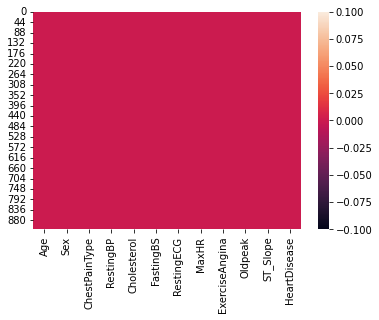

In [6]:
print(sns.heatmap(df.isnull()))

**This shows that there are no null values and are data is absolutely clean**

Let's see how many positive (1) and negative (0) samples we have in our dataframe

In [7]:
df.HeartDisease.value_counts()

yes    508
no     410
Name: HeartDisease, dtype: int64

Since these two values are close to even, our target column can be considered balanced. An unbalanced target column, meaning some classes have far more samples, can be harder to model than a balanced set, all of your target classes have the same number of samples.



In [8]:
df.HeartDisease.value_counts(normalize=True)

yes    0.553377
no     0.446623
Name: HeartDisease, dtype: float64

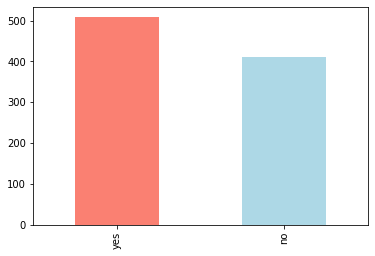

In [9]:
df.HeartDisease.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [10]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,no,Normal,172,N,0.0,Up,no
1,49,F,NAP,160,180,no,Normal,156,N,1.0,Flat,yes
2,37,M,ATA,130,283,no,ST,98,N,0.0,Up,no
3,48,F,ASY,138,214,no,Normal,108,Y,1.5,Flat,yes
4,54,M,NAP,150,195,no,Normal,122,N,0.0,Up,no


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 86.2+ KB


In [12]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


**I can notice that is unreal values for some columns like in the RestingBP no one have a 0 Resting BP**

# Exploring Data Analysis

In [13]:
fig = px.pie(df, names='HeartDisease', color_discrete_sequence=['#D81E1F','#0D3383'])
fig.update_layout(title='% of Heart Disease Patients')
# tmp = {"yyep","nope"}
# fig.update_layout(legend = tmp)
fig.show()

More than 55% of the data are a heart patient

In [14]:
fig = px.histogram(df, x="Age", marginal="box")
fig.update_layout(title='Age Distribution')
fig.show()

Most ages in the range 47 to 60 years

In [15]:
fig = px.histogram(df, x="Age", color="HeartDisease", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()

We can see that the probability of heart disease increase with the increase in age. The oldest people have a big chance to be a heart patient.

In [16]:
fig = px.pie(df, names='Sex',color_discrete_sequence=['#D81E1F','#0D3383'])
fig.update_layout(title='% of Sex')
fig.show()


In [17]:
fig = px.histogram(df, x="Sex",color='HeartDisease', barmode='group', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()
print()
print()
df.Sex.value_counts()

M    725
F    193
Name: Sex, dtype: int64

In [18]:
pd.crosstab(df.HeartDisease, df.Sex)

Sex,F,M
HeartDisease,,
no,143,267
yes,50,458


In [19]:
fig = px.histogram(df, x="Sex", color="HeartDisease", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()

The probability to be a heart patient in men more than in women. So men have more chances to be heart patients.

In [20]:
fig = px.pie(df, names='ChestPainType', color_discrete_sequence=['#D81E1F','#0D3383'])
fig.update_layout(title='% of Chest Pain Type')
fig.show()


**[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]**
* Most of the people in the dataset have (ASY)

In [21]:
fig = px.histogram(df, x="ChestPainType",color='HeartDisease', barmode='group', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()
print()
print()
df.ChestPainType.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [95]:
fig = px.histogram(df, x="ChestPainType", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of Chest Pain type")
fig.show()

In [22]:
fig = px.histogram(df, x="RestingBP", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of RestingBP")
fig.show()

In [23]:
fig = px.histogram(df, x="RestingBP",nbins=21, color="HeartDisease", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of RestingBP")
fig.show()

In [24]:
fig = px.scatter(df, x="Age", y="RestingBP", color=df["HeartDisease"].replace({0:"Not a heart patient", 1:"A heart patient"}), opacity=0.5)
fig.update_layout(title="Age VS RestingBP")
fig.show()

**For more details, we can split this figure into four quarters**
* First one (Age <= 50 and RestingBP <= 120): We can see with younger and normal RestingBP a low risk of heart disease
* Then (Age <= 50 and Resting >= 120): ِAlso here low risk of heart disease
* Then (Age > 50 and Resting < 120): With age, the incidence of heart disease increases even within the normal range of RestingBP
* Finally (Age > 50 and Resting > 120): Big chance of a heart disease

In [25]:
fig = px.histogram(df, x="Cholesterol", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of Cholesterol")
fig.show()

* less than 200 milligrams per deciliter (mg/dL) are considered healthy.
* between 200 and 239 mg/dL is borderline high.
* A reading of 240 mg/dL and above is considered high.

In [26]:
fig = px.histogram(df, x="Cholesterol", color="HeartDisease", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of Cholesterol")
fig.show()

In [27]:
fig = px.pie(df, names='FastingBS', color_discrete_sequence=['#0D3383','#D81E1F'])
fig.update_layout(title='% of FastingBS')
fig.show()

**Most of people don't have diabetes because the FastingBS in the normal range < 120**

In [28]:
fig = px.histogram(df, x="FastingBS",color='HeartDisease', barmode='group', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()
print()
print()
df.FastingBS.value_counts()

no     704
yes    214
Name: FastingBS, dtype: int64

**If a person has diabetes then he has a big chance of heart disease.**

In [29]:
fig = px.pie(df, names='RestingECG', color_discrete_sequence=['#D81E1F','#0D3383'])
fig.update_layout(title='% of RestingECG')
fig.show()

In [30]:
fig = px.histogram(df, x="RestingECG",color='HeartDisease', barmode='group', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()
print()
print()
df.RestingECG.value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [105]:
fig = px.scatter_3d(df, y='RestingBP', x='Age', z='RestingECG',color=df['HeartDisease'].replace({0:"No", 1:'Yes'}))
fig.update_layout(title="RestingBP vs Age vs RestingECG")
fig.show()

* When RestingECG is normal and HeartDisease is normal also isn't indicate anything, but when it has HeartDisease so we notice most of them are the oldest and have a high RestingBP rate.
* When RestingECG is ST most of them have a high RestingBP rate, also we can see most people who have HeartDisease are over 40 years old and most of them are over 55 years old.
* When RestingECG is LVH most of them are old and have very high RestingBP

In [32]:
fig = px.histogram(df, x="MaxHR", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of MaxHR")
fig.show()

In [33]:
fig = px.histogram(df, x="MaxHR",nbins=25, color="HeartDisease", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of Cholesterol")
fig.show()

In [34]:
fig = px.scatter_3d(df, x='RestingBP', y='MaxHR', z='Age',color=df['HeartDisease'].replace({0:"No", 1:'Yes'}))
fig.update_layout(title="RestingBP vs MaxHR vs Age")
fig.show()

**Because HR rate is dependent on age with equation (220 - age = normal HR) so we can see most people have Heart disease old and have high max HR and Resting BP is abnormal more than 120, But in normal people, we can see those old people have normal max HR and most of them have normal Resting BP.**

In [35]:
fig = px.histogram(df, x="ExerciseAngina", color='HeartDisease', barmode='group', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()
print()
print()
df.ExerciseAngina.value_counts()


N    547
Y    371
Name: ExerciseAngina, dtype: int64

**People who have exercise-induced angina have a big chance to have heart disease.**

In [36]:
fig = px.histogram(df, x="Oldpeak",nbins=10, marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of Oldpeak")
fig.show()

In [37]:
fig = px.histogram(df, x="Oldpeak",nbins=10, color="HeartDisease", marginal="box", histnorm='probability density', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.update_layout(title="Distribution of MaxHR")
fig.show()

**If oldpeak < 1 that mean low risk, otherwise high risk.**

In [38]:
fig = px.histogram(df, x="ST_Slope", color='HeartDisease', barmode='group', color_discrete_map={0:'#0D3383',1:'#D81E1F'})
fig.show()
print()
print()
df.ST_Slope.value_counts()


Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

**Upsloping is the best because it is a low chance of heart disease. but for flat and downsloping,  it's a high probability of being heart disease.**

In [39]:
df_column = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig = go.Figure()
for i in df_column:
    fig.add_trace(go.Box(y=df[i], name=i))
fig.show()   

**RestingBP, Cholesterol, and Oldpeak have some outliers but we don't remove all these outliers because maybe these outliers indicate to the patient. But we have zero and no one has RestingBP, Cholesterol, or Oldpeak equal zero it is impossible. So we gonna remove it.**

# Machine Learning Model


In [40]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [41]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [42]:
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve


In [43]:
corr_matrix = df.corr()
corr_matrix

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.254399,-0.095282,-0.382045,0.258612
RestingBP,0.254399,1.000000,0.100893,-0.112135,0.164803
Cholesterol,-0.095282,0.100893,1.000000,0.235792,0.050148
MaxHR,-0.382045,-0.112135,0.235792,1.000000,-0.160691
Oldpeak,0.258612,0.164803,0.050148,-0.160691,1.000000


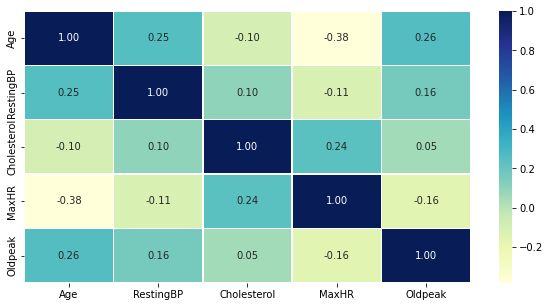

In [44]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

A higher positive value means a potential positive correlation (increase) and a higher negative value means a potential negative correlation (decrease

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb30a4580d0>,
      dtype=object)

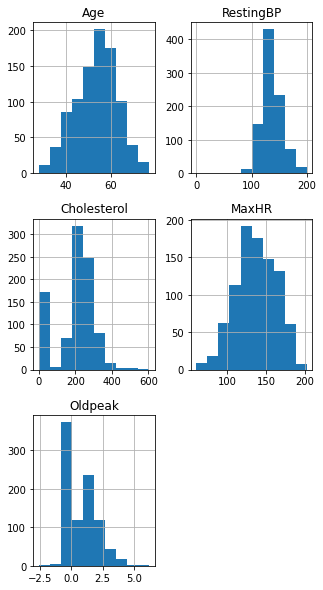

In [45]:
fig = plt.figure(figsize = (5,10))
ax = fig.gca()
df.hist(ax = ax)

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [70]:
# Everything except target variable
x = df.drop("HeartDisease", axis=1)

# Target variable
y = df["HeartDisease"]

#x= df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10]].values
#y= df.iloc[:, 11].values


In [48]:
x.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,no,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,no,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,no,ST,98,N,0.0,Up
3,48,F,ASY,138,214,no,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,no,Normal,122,N,0.0,Up


In [49]:
y.head()

0     no
1    yes
2     no
3    yes
4     no
Name: HeartDisease, dtype: object

In [80]:
# Random seed for reproducibility
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 0)

In [81]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
592,61,1,0,64,145,1,0,76,1,2.0,0
825,59,1,3,58,146,0,0,85,0,0.2,1
720,48,1,0,25,132,0,0,92,0,0.5,1
741,62,1,0,22,125,0,1,26,1,1.8,1
17,43,0,1,22,59,0,1,91,0,0.0,2


In [71]:
np.array(y_train), len(y_train)

(array(['yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes',
        'yes', 'no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no',
        'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes',
        'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no',
        'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes',
        'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes',
        'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes',
        'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes',
        'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes',
        'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no',
        'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'no',
        'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no',
        'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes',
        'yes', 'no', 'no', 'yes', 'no', 'n

In [53]:
np.array(y_test), len(y_test)

(array(['yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no',
        'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no',
        'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no',
        'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no',
        'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes',
        'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no',
        'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',
        'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no',
        'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no',
        'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no',
        'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes',
        'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes',
        'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes',
        'yes', 'yes', 'no', 'yes', 'yes', 

Now we've got our data prepared, we can start to fit models. we'll be using the following and comparing their results.

Logistic Regression - LogisticRegression()
K-Nearest Neighbors - KNeighnoursClassifier()
RandomForest - RandomForestClassifier()

In [75]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['HeartDisease']=le.fit_transform(df['HeartDisease'])
df['Sex']=le.fit_transform(df['Sex'])
df['RestingBP']=le.fit_transform(df['RestingBP'])
df['RestingECG']=le.fit_transform(df['RestingECG'])
df['Cholesterol']=le.fit_transform(df['Cholesterol'])
df['ChestPainType']=le.fit_transform(df['ChestPainType'])
df['FastingBS']=le.fit_transform(df['FastingBS'])
df['ExerciseAngina']=le.fit_transform(df['ExerciseAngina'])
df['MaxHR']=le.fit_transform(df['MaxHR'])
df['ST_Slope']=le.fit_transform(df['ST_Slope'])

df1=df.copy()
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,41,147,0,1,98,0,0.0,2,0
1,49,0,2,55,40,0,1,82,0,1.0,1,1
2,37,1,1,31,141,0,2,25,0,0.0,2,0
3,48,0,0,39,72,0,1,34,1,1.5,1,1
4,54,1,2,49,53,0,1,48,0,0.0,2,0


In [77]:
X_train.drop("Sex",axis=1)

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
592,61,ASY,190,287,yes,LVH,150,Y,2.0,Down
825,59,TA,170,288,no,LVH,159,N,0.2,Flat
720,48,ASY,124,274,no,LVH,166,N,0.5,Flat
741,62,ASY,120,267,no,Normal,99,Y,1.8,Flat
17,43,ATA,120,201,no,Normal,165,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...
835,54,ASY,110,239,no,Normal,126,Y,2.8,Flat
192,48,ATA,130,245,no,Normal,160,N,0.0,Up
629,57,ASY,128,303,no,LVH,159,N,0.0,Up
559,64,ASY,134,273,no,Normal,102,Y,4.0,Down


In [82]:
from sklearn.preprocessing import StandardScaler
st_x= StandardScaler()
X_train= st_x.fit_transform(X_train)
X_test= st_x.transform(X_test)


In [67]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)
skf = StratifiedKFold(n_splits=5 ,random_state=10, shuffle=True)

In [66]:


# Logistic Regression
logisticRegression = LogisticRegression(random_state = 5, max_iter=1000, solver = 'liblinear')
logisticRegression_parameter = {'C': np.arange(0.1, 1.1, 0.1), 'penalty': ['l1', 'l2']}

# SVM
svc = SVC(random_state = 5, max_iter=10000)
svc_parameter = {}
# RandomForestClassifier
randomForestClassifier = RandomForestClassifier(random_state=5)
randomForestClassifier_parameter = {}
# GradientBoostingClassifier
gradientBoostingClassifier = GradientBoostingClassifier()
gradientBoostingClassifier_parameter = {}
# knn
knn = KNeighborsClassifier(n_jobs=-1)
knn_parameter = {'n_neighbors': range(3, 30, 1), 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'p':[1, 2]}

In [68]:
models = [("LogisticRegression", logisticRegression, logisticRegression_parameter),
          ("SVC", svc, svc_parameter),
          ("RandomForestClassifier", randomForestClassifier, randomForestClassifier_parameter),
          ("GradientBoostingClassifier", gradientBoostingClassifier, gradientBoostingClassifier_parameter),
          ("KNN", knn, knn_parameter)
         ]

In [83]:
result = defaultdict(list)
for Etype, X, y in [("oneHotEncoder", x, y), ("labelEncoder", x, y)]:
    for name, model, param in models:
        gridSearchCV = GridSearchCV(model, param)
        gridSearchCV.fit(x, y)
        result['Model'].append(name)
        result['best_score'].append(gridSearchCV.best_score_)
        result['best_params'].append(gridSearchCV.best_params_)
        result['type'].append(Etype)
        print("Model: ", name, " finish with score: ", gridSearchCV.best_score_)

Model:  LogisticRegression  finish with score:  0.8169814682822523
Model:  SVC  finish with score:  0.6906331670230459
Model:  RandomForestClassifier  finish with score:  0.8234735091470657
Model:  GradientBoostingClassifier  finish with score:  0.8180149679258731
Model:  KNN  finish with score:  0.7374792112140651
Model:  LogisticRegression  finish with score:  0.8169814682822523
Model:  SVC  finish with score:  0.6906331670230459
Model:  RandomForestClassifier  finish with score:  0.8234735091470657
Model:  GradientBoostingClassifier  finish with score:  0.8180149679258731
Model:  KNN  finish with score:  0.7374792112140651


In [ ]:
result = pd.DataFrame(result)
result = result.sort_values(by="best_score", ascending=False)
result

,Model,best_score,best_params,type
2,RandomForestClassifier,0.823474,{},oneHotEncoder
7,RandomForestClassifier,0.823474,{},labelEncoder
3,GradientBoostingClassifier,0.818015,{},oneHotEncoder
8,GradientBoostingClassifier,0.818015,{},labelEncoder
0,LogisticRegression,0.816981,"{'C': 0.30000000000000004, 'penalty': 'l1'}",oneHotEncoder
5,LogisticRegression,0.816981,"{'C': 0.30000000000000004, 'penalty': 'l1'}",labelEncoder
4,KNN,0.737479,"{'algorithm': 'auto', 'n_neighbors': 19, 'p': ...",oneHotEncoder
9,KNN,0.737479,"{'algorithm': 'auto', 'n_neighbors': 19, 'p': ...",labelEncoder
1,SVC,0.690633,{},oneHotEncoder
6,SVC,0.690633,{},labelEncoder


In [84]:
fig = px.histogram(result, x="Model", y='best_score', color="type",text_auto=True, barmode='group', color_discrete_map={"labelEncoder":'#0D3383',"oneHotEncoder":'#D81E1F'})
fig.show()


**Best Model accuracy is Random Forest Classifier with 82.34% Accuracy**

In [85]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state= 5, test_size=0.25)

In [86]:
rf_model = RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=100)

In [87]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=4)

In [88]:
rf_model.score(X_test, y_test)

0.8869565217391304

In [89]:
y_pred = rf_model.predict(X_test)

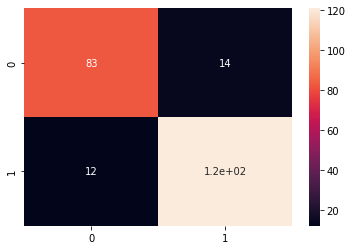

In [90]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [91]:
print(accuracy_score(y_test,y_pred))

0.8869565217391304


In [92]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86        97
           1       0.90      0.91      0.90       133

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230

